## Predicting outcomes by splitting data

In [5]:
import pandas as pd

# load data from github
filename = 'https://github.com/lmassaron/datasets/'
filename += 'releases/download/1.0/tennis.feather'
tennis = pd.read_feather(filename)

In [6]:
tennis.head()

,outlook,temperature,humidity,wind,play
0,Sunny,Hot,High,Weak,0
1,Sunny,Hot,High,Strong,0
2,Sunny,Mild,High,Weak,0
3,Sunny,Mild,Normal,Strong,1
4,Sunny,Cool,Normal,Weak,1


In [2]:
X = tennis[['outlook', 'temperature',
            'humidity', 'wind']]
X = pd.get_dummies(X)
y = tennis.play

In [7]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X, y)

DecisionTreeClassifier()

In [9]:
!pip install dtreeviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.8 MB/s eta 0:00:00


In [24]:
!sudo apt install msttcorefonts -qq

The following additional packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-chardet
  python3-debconf python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ubuntu-advantage-tools ubuntu-pro-client
  ubuntu-pro-client-l10n ubuntu-release-upgrader-core update-manager-core
  update-notifier-common xfonts-encodings xfonts-utils zstd
Suggested packages:
  shunit2
The following NEW packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-chardet
  python3-debconf python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ttf-mscorefonts-installer
  ubuntu-advantage-tools ubuntu-pro-client ubuntu-pro-client-l10n
  ubuntu-release-upgrader-core update-manager-core update-notifier-common
  xfonts-encodings xfonts-utils zstd
0 upgraded, 21 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,350 kB of archives.
After this operation, 9,834 kB of additional

In [25]:
rm ~/.cache/matplotlib -rf           # remove cache

In [28]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [29]:
from dtreeviz import dtreeviz

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
/usr/local/lib/python3.10/dist-packages/dtreeviz/models/shadow_decision_tree.py:291: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6775: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6790: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


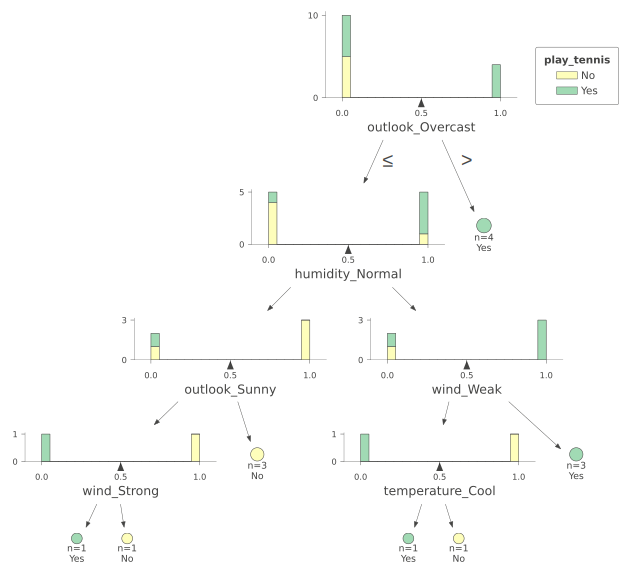

In [30]:
import dtreeviz
viz = dtreeviz.model(dt, X, y,
           target_name='play_tennis',
           feature_names=X.columns,
           class_names=["No", "Yes"])

# In a notebook, you can render inline without calling show()
viz.view(scale=1.4)
# Uncomment to save with scale 1
#vizRender = viz.view(scale=1)
#vizRender.save("play_tennis_decision_tree.svg")

## Pruning overgrown trees

In [31]:
filename = 'https://github.com/lmassaron/datasets/'
filename += 'releases/download/1.0/titanic.feather'
titanic = pd.read_feather(filename)

In [32]:
from sklearn.model_selection import train_test_split

X = titanic.iloc[:,:-1]
y = titanic.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True)

In [34]:
dt = DecisionTreeClassifier(min_samples_split=5)
dt.fit(X_train, y_train)
accuracy = dt.score(X_test, y_test)

print(f"test accuracy: {accuracy:0.3}")

test accuracy: 0.777


In [35]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

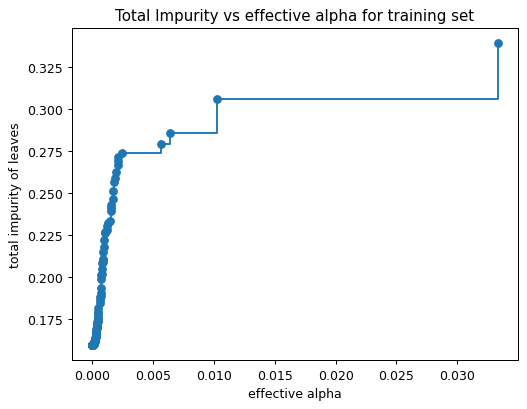

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=90)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [37]:
best_pruning = list()
for ccp_alpha in ccp_alphas:
    if ccp_alpha > 0:
        dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        dt.fit(X_train, y_train)
        best_pruning.append([ccp_alpha, dt.score(X_test, y_test)])

best_pruning = sorted(best_pruning, key=lambda x:x[1], reverse=True)

In [38]:
best_ccp_alpha = best_pruning[0][0]
dt = DecisionTreeClassifier(random_state=0,
                            ccp_alpha=best_ccp_alpha)
dt.fit(X_train, y_train)
accuracy = dt.score(X_test, y_test)

print(f"test accuracy: {accuracy:0.3}")

test accuracy: 0.805


In [39]:
print("Number of nodes in the last tree is: {} with ccp_alpha: {:0.3}"
      .format(dt.tree_.node_count, best_ccp_alpha))

Number of nodes in the last tree is: 13 with ccp_alpha: 0.0025


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


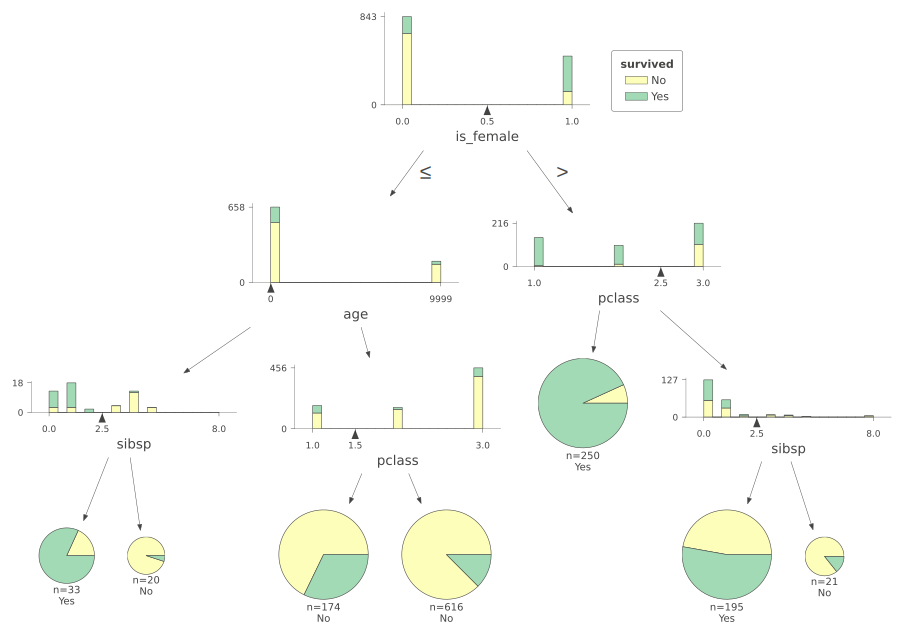

In [41]:
viz = dtreeviz.model(dt, X, y,
           target_name='survived',
           feature_names=X.columns,
           class_names=["No", "Yes"])

viz.view(scale=1.5)

# Taking a Probabilistic Turn

## Understanding Naïve Bayes

In [42]:
pd.crosstab(tennis.outlook,
            tennis.play.replace({0:'NO', 1:'YES'}))

play,NO,YES
outlook,,
Overcast,0,4
Rain,2,3
Sunny,3,2


In [43]:
pd.crosstab(tennis.outlook,
            tennis.play.replace({0:'NO', 1:'YES'}),
            normalize='columns')

play,NO,YES
outlook,,
Overcast,0.0,0.444444
Rain,0.4,0.333333
Sunny,0.6,0.222222


In [44]:
prob_outcomes = tennis.play.value_counts(sort=False,
                                         normalize=True)
outlook = pd.crosstab(tennis.outlook, tennis.play,
                      normalize='columns')
temperature = pd.crosstab(tennis.temperature, tennis.play,
                          normalize='columns')
humidity =  pd.crosstab(tennis.humidity, tennis.play,
                        normalize='columns')
wind = pd.crosstab(tennis.wind, tennis.play,
                   normalize='columns')

In [45]:
proba = prob_outcomes
proba *= outlook.loc["Sunny"]
proba *= temperature.loc["Mild"]
proba *= humidity.loc["Normal"]
proba *= wind.loc["Weak"]

print(proba)

play
0    0.006857
1    0.028219
Name: proportion, dtype: float64


## Estimating response with Naïve Bayes

In [46]:
filename = 'https://github.com/lmassaron/datasets/'
filename += 'releases/download/1.0/spam.feather'
spam = pd.read_feather(filename)

In [47]:
X = spam.iloc[:,:-1]
y = spam.iloc[:, -1]

In [48]:
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()

preds = cross_val_predict(nb, X, y, cv=5, n_jobs=-1)

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(y_true=y, y_pred=preds,
                           target_names=['non spam', 'spam'])
print(cr)

              precision    recall  f1-score   support

    non spam       0.89      0.92      0.90      2788
        spam       0.87      0.82      0.84      1813

    accuracy                           0.88      4601
   macro avg       0.88      0.87      0.87      4601
weighted avg       0.88      0.88      0.88      4601

